# **Tugas 3 Transformer**
### Mata Kuliah Deep Learning dan NLP
# ----
### Kelompok 17
### - Mohammad Raihan Aulia Kamil (2205449)
### - Muhamad Fahreza Fauzan (2204509)

## **Klasifikasi Sentimen Ulasan Aplikasi Gojek di Playstore**

### **1. Import Library**

In [ ]:
# Import library
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import os

### **2. Data Preparation**

#### Load Dataset

In [ ]:
# gdown for downloading files directly from Google Drive.
from gdown import download

id = "12geTVjlR-hWlFtj7fQbQZ5syMt8HepaU"
output = "gojek.csv"
download(id=id, output=output)

# Membaca dataset
df = pd.read_csv("gojek.csv")

Downloading...
From (original): https://drive.google.com/uc?id=12geTVjlR-hWlFtj7fQbQZ5syMt8HepaU
From (redirected): https://drive.google.com/uc?id=12geTVjlR-hWlFtj7fQbQZ5syMt8HepaU&confirm=t&uuid=88c7c8bc-889d-4540-a77e-44a1f75316d5
To: /content/gojek.csv
100%|██████████| 312M/312M [00:03<00:00, 84.3MB/s]


In [ ]:
# Cek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026000 entries, 0 to 1025999
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   reviewId              1026000 non-null  object
 1   userName              1026000 non-null  object
 2   userImage             1026000 non-null  object
 3   content               1025993 non-null  object
 4   score                 1026000 non-null  int64 
 5   thumbsUpCount         1026000 non-null  int64 
 6   reviewCreatedVersion  783377 non-null   object
 7   at                    1026000 non-null  object
 8   replyContent          145180 non-null   object
 9   repliedAt             145180 non-null   object
 10  appVersion            783377 non-null   object
dtypes: int64(2), object(9)
memory usage: 86.1+ MB


#### Data Selection
Hanya memilih kolom '*content*' (ulasan) dan '*score*' (rating bintang 1-5)

In [ ]:
# Mengambil kolom yang dibutuhkan saja
df_train = df[['content', 'score']].copy()

In [ ]:
# Menentukan nilai rating yang ingin dipertahankan
sentimen = [5, 1]

# Filter DataFrame untuk hanya menyertakan baris dengan score 5 atau 1
df_filtered = df_train[df_train['score'].isin(sentimen)].copy()

# Cek kembali jumlah barisnya
print(f"Jumlah baris setelah filter: {len(df_filtered)}")

# Cek kembali jumlah Rating yang tersisa
print("\nJumlah Rating yang tersisa:")
print(df_filtered['score'].value_counts())

Jumlah baris setelah filter: 884665

Jumlah Rating yang tersisa:
score
5    692295
1    192370
Name: count, dtype: int64


#### Data Transformation
Mengubah rating 5 menjadi 1 (Sentimen Positif) dan rating 1 menjadi 0 (Sentimen Negatif)  


In [ ]:
# Membuat kolom label
# Jika Rating = 5, berikan nilai 1 (Positif).
# Jika tidak, berikan nilai 0 (Negatif).
df_filtered['label'] = np.where(
    df_filtered['score'] == 5,   # Kondisi
    1,                           # Nilai jika True (score 5)
    0                            # Nilai jika False (score 1)
)

# Menghapus kolom score (sudah tidak diperlukan)
df_train = df_filtered.drop(['score'], axis = 1)

# Cek 5 baris pertama dengan kolom baru
print(df_train.head())

# Cek distribusi label baru
print("\nDistribusi Sentimen_Label:")
print(df_train['label'].value_counts())

                                             content  label
3  mantapp gojek paling nyaman kalo pesen pake gojek      1
4     sejauh ini yang paling nyaman,aman dan praktis      1
5  kenapa map sering melenceng padahal sudah dise...      0
6                        sangat membantu bravo gojek      1
8  aplikasinya kk sangat bagus dan bermanfaat kk ...      1

Distribusi Sentimen_Label:
label
1    692295
0    192370
Name: count, dtype: int64


#### Penanganan Data Duplikat dan Nilai *NULL*

In [ ]:
print(df_train.duplicated().sum())

411719


In [ ]:
df_train = df_train.drop_duplicates()
print(df_train.duplicated().sum())
df_train.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 472946 entries, 3 to 1025999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  472944 non-null  object
 1   label    472946 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.8+ MB


In [ ]:
print(df_train.isnull().sum())

content    2
label      0
dtype: int64


In [ ]:
df_train = df_train.dropna()
print(df_train.isnull().sum())

content    0
label      0
dtype: int64


#### Preprocessing Teks

In [ ]:
# Cek data sebelum preprocessing
df_train.head(10)

,content,label
3,mantapp gojek paling nyaman kalo pesen pake gojek,1
4,"sejauh ini yang paling nyaman,aman dan praktis",1
5,kenapa map sering melenceng padahal sudah dise...,0
6,sangat membantu bravo gojek,1
8,aplikasinya kk sangat bagus dan bermanfaat kk ...,1
9,ganjen banget suami orang di panggil sayang sa...,0
10,apk m0nyet . gw bayar bukan numpang,0
11,"Senang pake Go-Jek, . terima kasih 🙏 puaass 🙏",1
12,"kalo masang iklan yg bener, jangan maksa di su...",0
14,"Suspensi motornya masih mantap, jalannya santa...",1


In [ ]:
# --- Lowercasing ---
df_train['content'] = df_train['content'].str.lower()

# --- Menghapus Angka dan Tanda Baca ---
def remove_punct_and_numbers(text):
    # Hapus URL
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Hapus angka
    text = re.sub(r'\d+', '', text)
    # Hapus tanda baca. Kita menggunakan string.punctuation.
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_train['content'] = df_train['content'].apply(remove_punct_and_numbers)


# --- Hapus Emotikon dan Simbol Lain yang Tidak Perlu ---
def remove_emojis(text):
    # Pola RegEx untuk menangani sebagian besar emotikon dan simbol umum
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emotikon (Smiley)
        "\U0001F300-\U0001F5FF"  # Simbol & Piktograf
        "\U0001F680-\U0001F6FF"  # Transportasi & Peta
        "\U0001F1E0-\U0001F7FF"  # Bendera, Geometrik, Dll
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df_train['content'] = df_train['content'].apply(remove_emojis)

# Cek data sesudah preprocessing
df_train.head(10)

,content,label
3,mantapp gojek paling nyaman kalo pesen pake gojek,1
4,sejauh ini yang paling nyamanaman dan praktis,1
5,kenapa map sering melenceng padahal sudah dise...,0
6,sangat membantu bravo gojek,1
8,aplikasinya kk sangat bagus dan bermanfaat kk ...,1
9,ganjen banget suami orang di panggil sayang sa...,0
10,apk mnyet gw bayar bukan numpang,0
11,senang pake gojek terima kasih puaass,1
12,kalo masang iklan yg bener jangan maksa di sur...,0
14,suspensi motornya masih mantap jalannya santai...,1


In [ ]:
# Melakukan pembersihan data duplikat akhir
print(df_train.duplicated().sum())
df_train = df_train.drop_duplicates()
print(df_train.duplicated().sum())

34511
0


In [ ]:
# Cek informasi dataset terakhir
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 438433 entries, 3 to 1025999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  438433 non-null  object
 1   label    438433 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.0+ MB


#### Memeriksa Distribusi Label Positif dan Negatif dengan Visualisasi

In [ ]:
df_train['label'].value_counts()

,count
label,
1,260106
0,178327


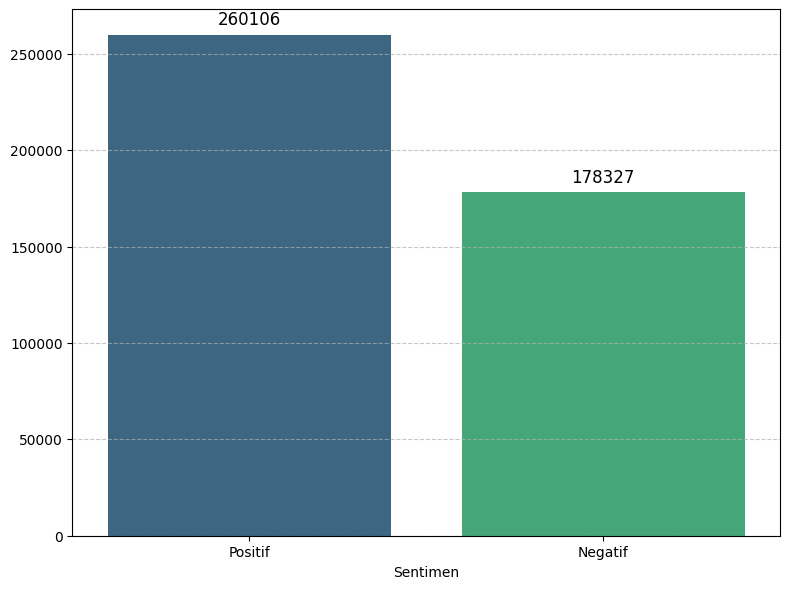

In [ ]:
# --- Visualisasi ---

# Bar Plot
# Buat kamus untuk label yang lebih mudah dibaca
sentimen_counts = df_train['label'].value_counts()
label_map = {1: 'Positif', 0: 'Negatif'}
plot_labels = [label_map[label] for label in sentimen_counts.index]

plt.figure(figsize=(8, 6))

# Buat Bar Plot
sns.barplot(x=plot_labels, y=sentimen_counts.values, hue=plot_labels, palette='viridis', legend=False)

# Tambahkan label nilai di atas bar
for i, count in enumerate(sentimen_counts.values):
    plt.text(i, count + 5000, str(count), ha='center', fontsize=12)

plt.xlabel('Sentimen')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

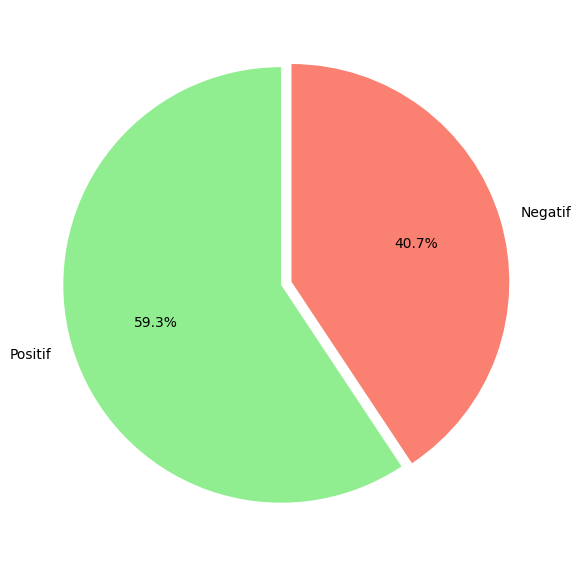

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    sentimen_counts.values,
    labels=plot_labels,
    autopct='%1.1f%%', # Menampilkan persentase dengan 1 angka di belakang koma
    colors=['lightgreen', 'salmon'],
    startangle=90,
    explode=(0.05, 0) # Sedikit pisahkan slice Positif
)
plt.tight_layout()
plt.show()

#### Visualisasi Word Cloud

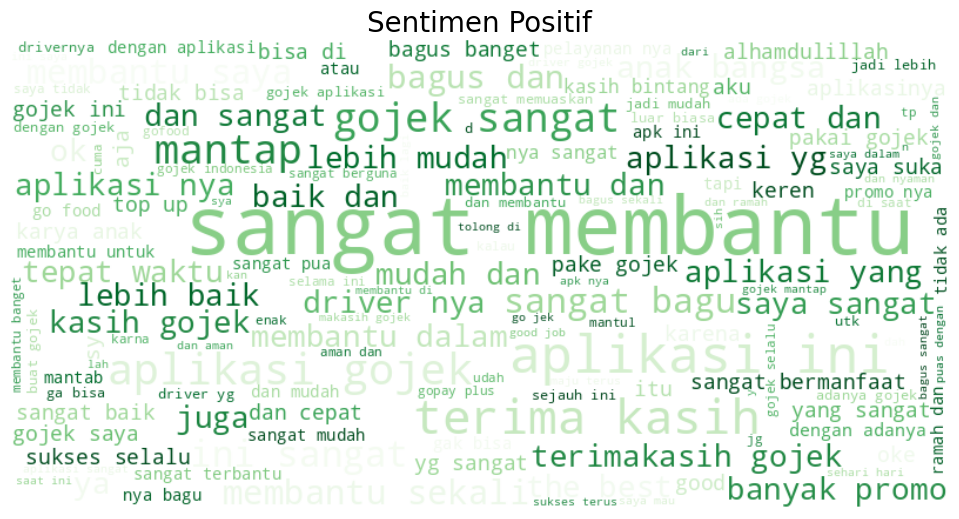

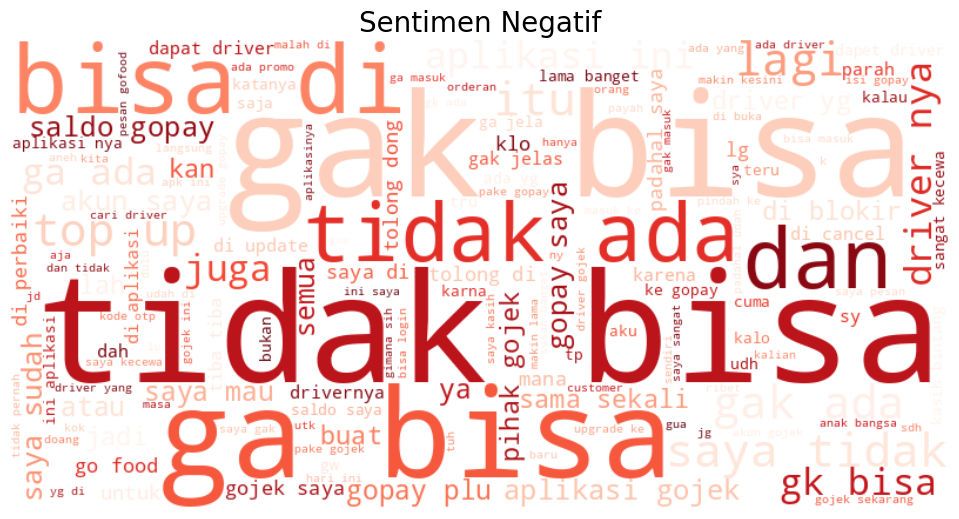

In [ ]:
# Membuat Word Cloud

# --- Pemisahan Teks berdasarkan Sentimen ---

# Gabungkan semua teks positif menjadi satu string panjang
positive_text = " ".join(
    df_train[df_train['label'] == 1]['content'].astype(str)
)

# Gabungkan semua teks negatif menjadi satu string panjang
negative_text = " ".join(
    df_train[df_train['label'] == 0]['content'].astype(str)
)

# --- Konfigurasi WordCloud ---

# Tentukan stopwords
stopwords_list = set([])

# Fungsi untuk membuat dan menampilkan Word Cloud
def generate_wordcloud(text, title, color):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords_list,
        min_font_size=10,
        colormap=color # Misalnya 'Greens' atau 'Reds'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.tight_layout(pad=0)

# Word Cloud Sentimen Positif
generate_wordcloud(
    positive_text,
    'Sentimen Positif',
    'Greens' # Skema warna hijau untuk positif
)

# Word Cloud Sentimen Negatif
generate_wordcloud(
    negative_text,
    'Sentimen Negatif',
    'Reds' # Skema warna merah untuk negatif
)

plt.show()

#### Menghitung Jumlah Kata atau Vocabulary dengan Visualisasi

In [ ]:
# --- Hitung Jumlah Kata ---
df_train_copy = df_train
df_train_copy['word_count'] = df_train_copy['content'].apply(lambda x: len(str(x).split()))

# --- Cek Statistik Dasar ---
print("Statistik Jumlah Kata:")
print(df_train_copy['word_count'].describe())

Statistik Jumlah Kata:
count    438433.000000
mean         12.249083
std          13.426071
min           0.000000
25%           4.000000
50%           7.000000
75%          15.000000
max         302.000000
Name: word_count, dtype: float64


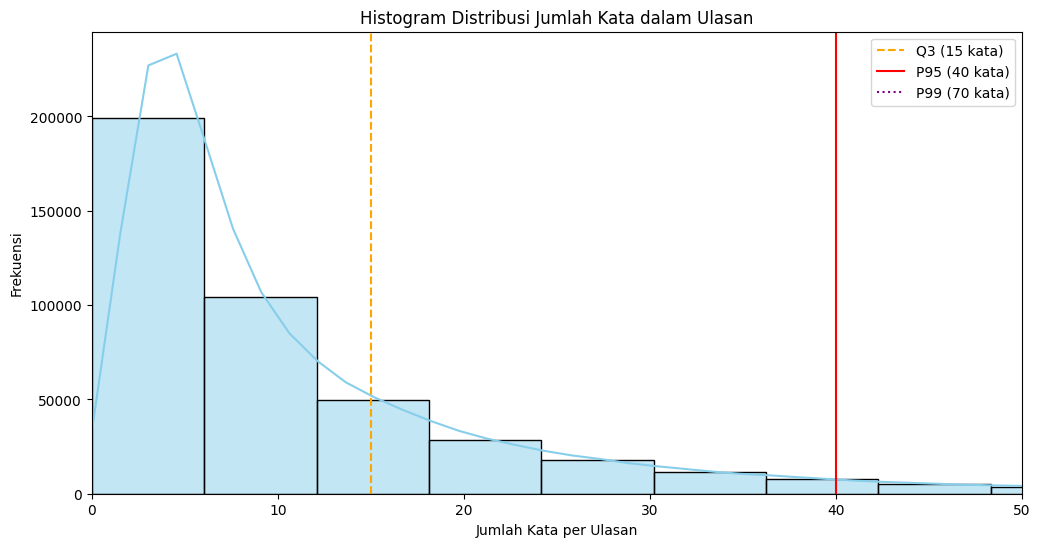

In [ ]:
# --- Visualisasi Histogram Distribusi Panjang Ulasan ---

plt.figure(figsize=(12, 6))
# Batasi sumbu X (misalnya, sampai 50 kata) agar grafik lebih fokus, karena sebagian besar ulasan pendek
sns.histplot(df_train_copy['word_count'], bins=50, kde=True, color='skyblue')

# Tampilkan garis untuk Q3 (Kuartil ke-3) atau Persentil 95
q3 = df_train_copy['word_count'].quantile(0.75)
p95 = df_train_copy['word_count'].quantile(0.95)
p99 = df_train_copy['word_count'].quantile(0.99)

plt.axvline(q3, color='orange', linestyle='--', label=f'Q3 ({q3:.0f} kata)')
plt.axvline(p95, color='red', linestyle='-', label=f'P95 ({p95:.0f} kata)')
plt.axvline(p99, color='purple', linestyle=':', label=f'P99 ({p99:.0f} kata)')

plt.title('Histogram Distribusi Jumlah Kata dalam Ulasan')
plt.xlabel('Jumlah Kata per Ulasan')
plt.ylabel('Frekuensi')
plt.xlim(0, 50) # Batasi tampilan hingga 50 kata untuk fokus
plt.legend()
plt.show()

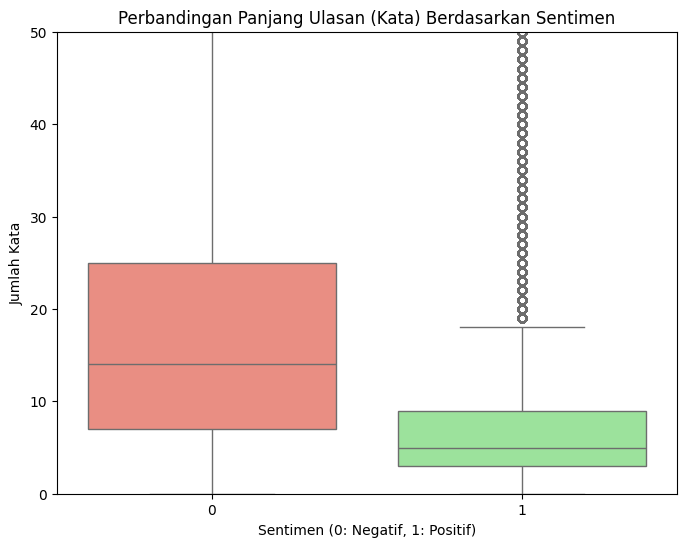

In [ ]:
# --- Visualisasi Box Plot Perbandingan Panjang Ulasan berdasarkan Sentimen ---

plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='word_count', hue='label', data=df_train_copy, palette=['salmon', 'lightgreen'], legend=False)

plt.title('Perbandingan Panjang Ulasan (Kata) Berdasarkan Sentimen')
plt.xlabel('Sentimen (0: Negatif, 1: Positif)')
plt.ylabel('Jumlah Kata')
plt.ylim(0, 50) # Batasi sumbu Y agar outlier tidak mendominasi
plt.show()

In [ ]:
# Menyimpan Dataframe untuk Model lain
df_train.to_csv('train.csv', index = False)

#### Definisi Parameter dan Tokenisasi

In [ ]:
# --- Definisi Parameter ---
MAX_VOCAB_SIZE = 30000
MAX_LEN = 40
OOV_TOKEN = "<UNK>"

# Pisahkan antara teks (fitur) dan label
texts = df_train['content'].astype(str)
labels = df_train['label'].values

print(f"Jumlah total data: {len(texts)}")

Jumlah total data: 438433


In [ ]:
# --- Tokenisasi ---

# Inisialisasi Keras Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV_TOKEN)

# Membangun kamus berdasarkan semua teks di 'texts'
tokenizer.fit_on_texts(texts)

# --- Konversi Teks ke Angka (Sequencing) ---
print("Mengubah teks menjadi urutan angka (sequences)...")
sequences = tokenizer.texts_to_sequences(texts)

# --- Padding ---
print(f"Melakukan padding pada sequences (panjang seragam: {MAX_LEN})...")
# 'post' berarti padding (angka 0) akan ditambahkan di akhir kalimat
padded_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Tampilkan sebagian dari kamus data (word_index)
word_index = tokenizer.word_index
print(f"Ukuran Vocabulary (total kata unik ditemukan): {len(word_index)}")
print("Contoh 10 kata pertama dalam kamus:")
print(list(word_index.items())[:10])
print(f"Token <UNK> direpresentasikan oleh angka: {word_index[OOV_TOKEN]}")
print(f"Token <PAD> (dibuat otomatis oleh pad_sequences) adalah angka: 0")

Mengubah teks menjadi urutan angka (sequences)...
Melakukan padding pada sequences (panjang seragam: 40)...

--- HASIL PREPROCESSING ---
Ukuran Vocabulary (total kata unik ditemukan): 175150
Contoh 10 kata pertama dalam kamus:
[('<UNK>', 1), ('saya', 2), ('gojek', 3), ('di', 4), ('dan', 5), ('aplikasi', 6), ('bisa', 7), ('nya', 8), ('sangat', 9), ('driver', 10)]
Token <UNK> direpresentasikan oleh angka: 1
Token <PAD> (dibuat otomatis oleh pad_sequences) adalah angka: 0


In [ ]:
print(f"Bentuk data padded (X): {padded_seq.shape}")
print(f"Bentuk data label (y): {labels.shape}")

Bentuk data padded (X): (438433, 40)
Bentuk data label (y): (438433,)


#### Split Data Training dan Validasi

In [ ]:
# --- Split Data Training & Validasi ---
# Kita sisihkan 10% data untuk validasi
X_train, X_val, y_train, y_val = train_test_split(
    padded_seq,
    labels,
    test_size=0.1,  # 10% untuk validasi
    random_state=42, # Untuk hasil yang konsisten
    stratify=labels   # Memastikan rasio positif/negatif sama di train/val
)

print(f"\nJumlah data training: {len(X_train)}")
print(f"Jumlah data validasi: {len(X_val)}")


Jumlah data training: 394589
Jumlah data validasi: 43844


#### Menentukan Class Weights untuk Imbalance Label

In [ ]:
# --- Hitung Class Weights (untuk Imbalance Data) ---
# Ini memberi "hukuman" lebih besar jika model salah menebak kelas minoritas
print("\nMenghitung class weights...")
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: weights[0], 1: weights[1]}
print(f"Bobot untuk Kelas 0 (Negatif): {weights[0]:.2f}")
print(f"Bobot untuk Kelas 1 (Positif): {weights[1]:.2f}")


Menghitung class weights...
Bobot untuk Kelas 0 (Negatif): 1.23
Bobot untuk Kelas 1 (Positif): 0.84


### **3. Arsitektur Model**

In [ ]:
# --- Definisi Arsitektur Model Transformer ---

# Hyperparameter Model
EMBED_DIM = 128  # d_model: Dimensi embedding
NUM_HEADS = 8    # Jumlah 'head' dalam Multi-Head Attention
FF_DIM = 512     # Dimensi lapisan Feed Forward
NUM_TRANSFORMER_BLOCKS = 2 # Jumlah 'Nx' (lapisan Encoder ditumpuk)
DROPOUT_RATE = 0.1

class TransformerBlock(layers.Layer):

    # Blok Encoder Transformer: Multi-Head Attention -> Add & Norm -> Feed Forward -> Add & Norm

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Lapisan Multi-Head Attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Lapisan Feed Forward
        self.ffn = tf.keras.Sequential([
                layers.Dense(ff_dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        ])
        # Lapisan Add & Norm
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # 1. Multi-Head Attention
        # (Untuk self-attention, Q, K, dan V semuanya adalah input yang sama)
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        # 2. Add & Norm (Residual connection)
        out1 = self.layernorm1(inputs + attn_output)

        # 3. Feed Forward
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # 4. Add & Norm
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

#### Menggabungkan Token Embedding dan Positional Encoding

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):

    # Menggabungkan token embedding dan positional encoding.

    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # Token Embedding (kamus kata)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Positional Encoding (kamus posisi)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # Buat 'positions' (dari 0, 1, 2, ..., maxlen-1)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        # Menjumlahkan kedua embedding
        return x + positions

#### Membangun Model

In [ ]:
# --- Membangun dan Meng-compile Model ---

def build_model():
    # Input layer
    inputs = layers.Input(shape=(MAX_LEN,))

    # 1. Embedding Layer
    # (Tambah 1 pada vocab size untuk token padding '0')
    embedding_layer = TokenAndPositionEmbedding(MAX_LEN, MAX_VOCAB_SIZE + 1, EMBED_DIM)
    x = embedding_layer(inputs)

    # 2. Encoder Blocks
    for _ in range(NUM_TRANSFORMER_BLOCKS):
        x = TransformerBlock(EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT_RATE)(x)

    # 3. Classification Head
    x = layers.GlobalAveragePooling1D()(x) # Mengambil rata-rata output token
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.2)(x)

    # Output layer (1 unit, sigmoid untuk probabilitas 0-1)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 40, 128)        │     3,845,248 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 40, 128)        │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 40, 128)        │       659,712 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168,833 (19.72 MB)

 Trainable params: 5,168,833 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

### **4. Training Model**

In [ ]:
# --- Melatih Model ---
EPOCHS = 10
BATCH_SIZE = 64

early_stop = EarlyStopping(
    monitor='val_loss',     # Pantau loss di data validasi
    patience=2,             # Hentikan jika 'val_loss' tidak membaik selama 2 epoch
    restore_best_weights=True # Simpan bobot terbaik, bukan bobot terakhir
)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop],
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict # Menerapkan bobot kelas
)

# --- Simpan Model ---
model.save("transformer.keras")
print("\nModel berhasil disimpan sebagai 'transformer.keras'")

Epoch 1/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 132s 19ms/step - accuracy: 0.7959 - loss: 1.2691 - val_accuracy: 0.8962 - val_loss: 0.9556
Epoch 2/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 111s 18ms/step - accuracy: 0.8993 - loss: 0.9103 - val_accuracy: 0.9035 - val_loss: 0.7888
Epoch 3/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 112s 18ms/step - accuracy: 0.9087 - loss: 0.7522 - val_accuracy: 0.9070 - val_loss: 0.6712
Epoch 4/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 113s 18ms/step - accuracy: 0.9132 - loss: 0.6410 - val_accuracy: 0.9100 - val_loss: 0.5846
Epoch 5/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 113s 18ms/step - accuracy: 0.9150 - loss: 0.5562 - val_accuracy: 0.9106 - val_loss: 0.5204
Epoch 6/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 112s 18ms/step - accuracy: 0.9183 - loss: 0.4881 - val_accuracy: 0.9101 - val_loss: 0.4739
Epoch 7/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 112s 18ms/step - accuracy: 0.9196 - loss: 0.4338 - val_accuracy: 0.9116 - val_loss: 0.4226
Epoch 8/10
6166/6166 ━━━━━━━━━━━━━━━━━━━━ 112s 18ms/step - accuracy: 

### **5. Evaluasi Model**

#### Visualisasi Plot Training dan Validasi


--- Memulai Evaluasi Model ---


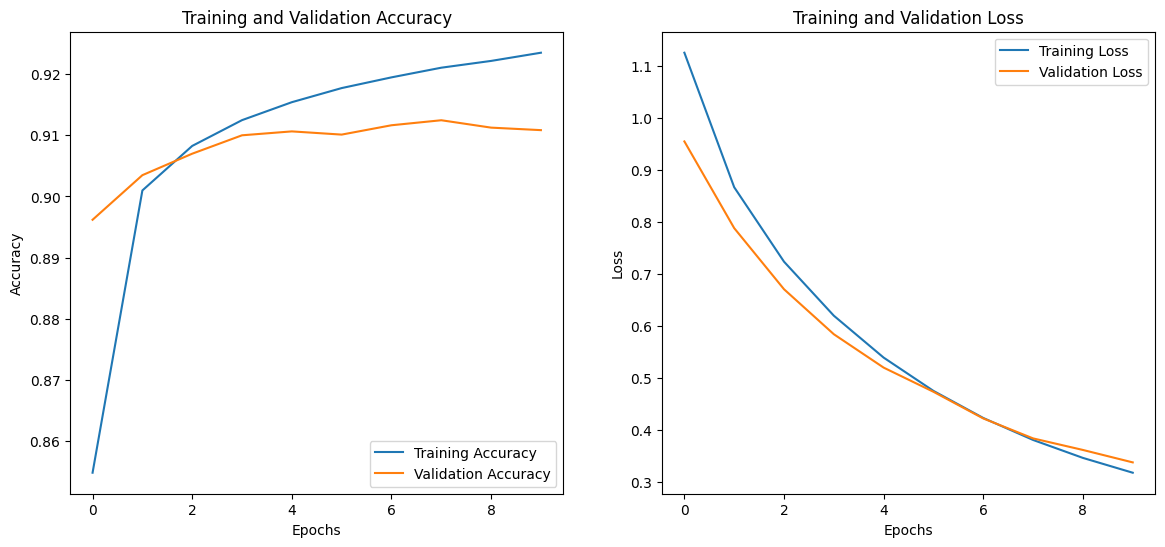

In [ ]:
# --- EVALUASI MODEL ---
print("\n--- Memulai Evaluasi Model ---")

# --- Visualisasi Plot Training & Validasi ---
# (Untuk mendeteksi overfitting)

# Ekstrak data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# Buat 1 gambar dengan 2 subplot (1 baris, 2 kolom)
plt.figure(figsize=(14, 6))

# Subplot 1: Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Tampilkan plot
plt.show()

#### Prediksi Data Validasi untuk Classification Report dan Confusion Matrix

In [ ]:
# --- Prediksi pada Data Validasi ---

# Dapatkan probabilitas prediksi
y_probs = model.predict(X_val)

# Konversi probabilitas menjadi kelas (0 atau 1) dengan threshold 0.5
y_preds = (y_probs > 0.5).astype(int).reshape(-1)

# --- C. Tampilkan Classification Report ---
print("\n--- Classification Report ---")
# Menampilkan Precision, Recall, F1-Score untuk tiap kelas
report = classification_report(y_val, y_preds, target_names=['Negatif (0)', 'Positif (1)'])
print(report)

1371/1371 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

--- Classification Report ---
              precision    recall  f1-score   support

 Negatif (0)       0.86      0.93      0.89     17833
 Positif (1)       0.95      0.90      0.92     26011

    accuracy                           0.91     43844
   macro avg       0.91      0.91      0.91     43844
weighted avg       0.91      0.91      0.91     43844




Membuat Confusion Matrix...


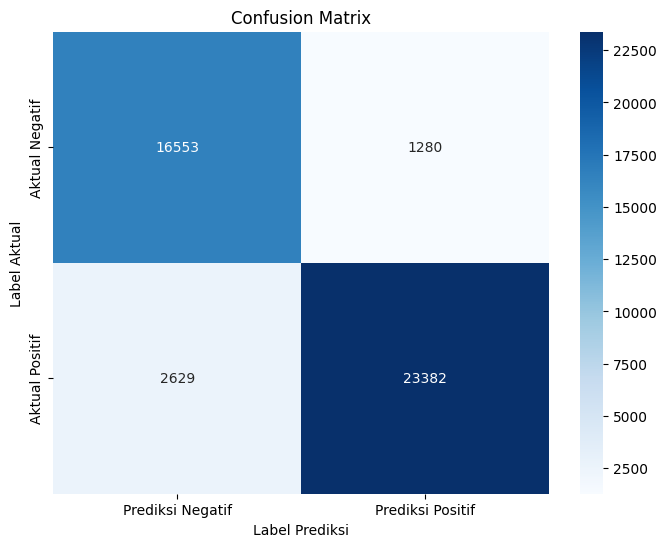

In [ ]:
# --- Visualisasi Confusion Matrix ---
print("\nMembuat Confusion Matrix...")
cm = confusion_matrix(y_val, y_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,     # Tampilkan angka di dalam kotak
    fmt='d',        # Format angka sebagai integer
    cmap='Blues',   # Skema warna
    xticklabels=['Prediksi Negatif', 'Prediksi Positif'],
    yticklabels=['Aktual Negatif', 'Aktual Positif']
)
plt.title('Confusion Matrix')
plt.ylabel('Label Aktual')
plt.xlabel('Label Prediksi')

# Tampilkan plot
plt.show()